In [8]:
import torch
from torchvision import transforms, datasets
from torchvision import models
from PIL import Image
import os
from efficientnet_pytorch import EfficientNet
import numpy as np
from sklearn.preprocessing import normalize
import json
from sklearn.metrics.pairwise import cosine_similarity
import random
import psycopg2
import time

In [4]:
def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    image = Image.open(image_path).convert("RGB")
    return transform(image).unsqueeze(0)

def generate_embedding(image_path, model):
    input_tensor = preprocess_image(image_path)
    with torch.no_grad():
        output = model(input_tensor)
    return output.squeeze().numpy()

In [5]:
# Working folders
img_directory = '../images/'

image_files = os.listdir(img_directory)

# dataset = datasets.ImageFolder(img_directory, transform=transform) # requires images to be in sub-directory
# dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

In [6]:
# model setting
model = EfficientNet.from_pretrained('efficientnet-b7')
model = model.eval()

Loaded pretrained weights for efficientnet-b7


In [7]:
embeddings = []
for filename in image_files:
    embedding = generate_embedding(os.path.join(img_directory, filename), model)
    embeddings.append(embedding)

print(f'There are {len(embeddings)} embedding vectors, each size is {len(embeddings[0])}')

There are 46579 embedding vectors, each size is 1000


In [20]:
p = psycopg2.connect(host="localhost", user="root", port=5432, database="W9sV6cL2dX", password="E5rG7tY3fH")

time_stamp = int(time.time())

embeddings_data = []

for index, embedding in enumerate(embeddings):
  embeddings_data.append((image_files[index].split(".jpg")[0], embedding.tolist(), time_stamp))

# print(embeddings_data[:3])
def save_embeddings(embeddings_data):
  INSERT_QUERY = """
      INSERT INTO item_embeddings (
        item_id,
        embedding,
        time_stamp
      ) VALUES (%s, %s, to_timestamp(%s))
    """
  
  cursor = p.cursor()
  cursor.executemany(INSERT_QUERY, embeddings_data)
  p.commit()
  
  # Close the cursor and connection
  cursor.close()
  p.close()
  
save_embeddings(embeddings_data)

In [54]:
embeddings_array = np.array(embeddings)

In [174]:
idx = random.randint(0, 999)
k = 3
cosine_similarities = cosine_similarity(embeddings_array)

nearest_neighbors_indices = np.argsort(cosine_similarities[idx])[-(k+1):-1][::-1]

print(f'{k} nearest neighbors indices of item[{idx}] are items: {nearest_neighbors_indices}')
print(f'For img {image_files[idx]}, model recommends img {image_files[nearest_neighbors_indices[0]]}')


3 nearest neighbors indices of item[241] are items: [203 514 103]
For img 7d9078c8-2802-46bf-9310-c4d0c4c967d1.jpg, model recommends img c360e0b5-473e-48c3-9173-8488da650d80.jpg


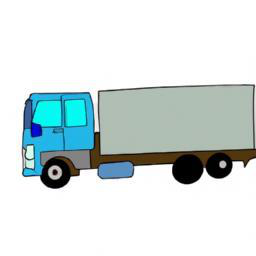

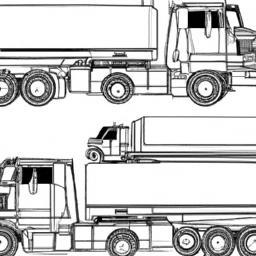

In [175]:
original_image_key = image_files[idx]
recommended_image_key = image_files[nearest_neighbors_indices[0]]
original_image = Image.open(os.path.join(img_directory, original_image_key))
recommended_image = Image.open(os.path.join(img_directory, recommended_image_key))

original_image.show()
recommended_image.show()